## Exporatory Data Analysis and First Round of Polynomial Regression



In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime as dt
import seaborn as sns

%matplotlib inline

### Create functions for use throughout the notebook

In [443]:
#create a function for producing initial insight into the dataframe

def initial_stats(df):
    print(df.head(), '\n')
    print('Number of missing values:\n', df.isna().sum(), '\n')
    print(df.shape, '\n')
    print(df.describe())
    rows_index = df.shape[0] - 1
    print('\nDate range is:', df.iloc[0,0], 'to', df.iloc[rows_index,0])
    

In [444]:
# create a list of the dataframes
df_list = []

# store the date value that is the soonest start date and the latest end date
date_range = []

# create a function for converting the timestamp to datetime and extracts date
def convert_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.drop(columns='timestamp')
    
    # find the soonest start date and latest end date
    start_date = min(df['date'])
    end_date = max(df['date'])
    if len(date_range) < 2:
        date_range.append(start_date)
        date_range.append(end_date)
    elif start_date > date_range[0]:
        date_range[0] = start_date
    elif end_date < date_range[1]:
        date_range[1] = end_date
        
    # append the list of dataframes
    df_list.append(df)
   
    return df

In [445]:
# create a function for adding a column of the one-day change values
# df is the dataframe to use, and col_val is the column index value

def add_change_col(df, col_val):
    df_up_one = df.iloc[1:, col_val]
    df_up = df_up_one.reset_index(drop=True)
    
    # get the percentage from one row to the next
    change_df = (df_up - df.iloc[:, col_val]) / df.iloc[:, col_val] * 100
    
    # fill in the first value with a dummy value of 0
    change_df = pd.concat([pd.Series([0]), change_df.iloc[:-1]])
    change_df = change_df.reset_index(drop=True)

    df['{}_change'.format(df.columns[col_val])] = change_df
    
    return df

## Price - Target Variable

In [446]:
# import price data and rough analysis
price = pd.read_csv(r'C:\Users\dagar\Bitcoin_Data_Capstone\price.csv')
initial_stats(price)

              timestamp     value
0  2010-07-17T00:00:00Z  0.049510
1  2010-07-18T00:00:00Z  0.085840
2  2010-07-19T00:00:00Z  0.080800
3  2010-07-20T00:00:00Z  0.074733
4  2010-07-21T00:00:00Z  0.079210 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3983, 2) 

              value
count   3983.000000
mean    4818.315246
std     9928.110057
min        0.049510
25%       85.049463
50%      581.290525
75%     6736.971907
max    63603.708172

Date range is: 2010-07-17T00:00:00Z to 2021-06-11T00:00:00Z


In [447]:
# convert the timestamp to datetime.date
price = convert_timestamp(price)

In [448]:
# rename the column from value to price
price.rename({'value' : 'price'}, axis=1, inplace=True)
price.head()

,price,date
0,0.049510,2010-07-17
1,0.085840,2010-07-18
2,0.080800,2010-07-19
3,0.074733,2010-07-20
4,0.079210,2010-07-21


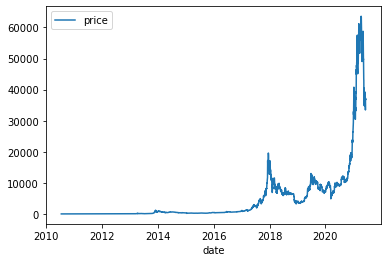

In [449]:
price.plot(kind='line', x='date', y='price')
plt.show()

In [450]:
# add a column that shows the daily change in price percentage
price = add_change_col(price, 0)

In [451]:
price.head()

,price,date,price_change
0,0.049510,2010-07-17,0.000000
1,0.085840,2010-07-18,73.379115
2,0.080800,2010-07-19,-5.871389
3,0.074733,2010-07-20,-7.508251
4,0.079210,2010-07-21,5.990187


In [452]:
price['price_change'].describe()

count    3983.000000
mean        0.487783
std         5.471416
min       -49.274119
25%        -1.355100
50%         0.198717
75%         2.088597
max        73.379115
Name: price_change, dtype: float64

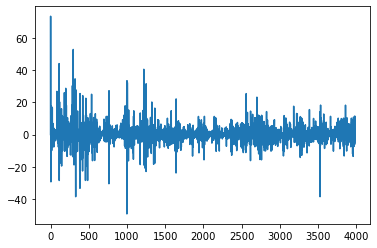

In [453]:
plt.plot(price['price_change'])

### Analysis of Target Variable- Price and Change in Price:
**Change in price** may be a better target for the prediction model. Because of the wide range of price values, even a small validation error may result in significant difference from the price value and predicted price value. Since the change of price percentage stays within a narrower range, the loss function may be a better indicator of the model's performance.

## Look at the future various prices

The primary problem in the field bitcoin price prediction is what the future price will be. By looking at current on-chain metrics, can the next day's price, or three days from now price be predicted. This can provide great knowledge for investors and allow them to plan they investing accordingly. By creating columns of various future prices, we can train the model to predict these values using current on-chain metrics.

#### Create values of price for next day, 7 days, 30 days, 90 days, and 180 days later.

In [454]:
one_day = price.iloc[1:, 0].reset_index().drop(columns='index').rename(columns={'price':'1_day'})
one_day_change = price.iloc[1:, 2].reset_index().drop(columns='index').rename(columns={'price_change':'1_day_change'})
three_day = price.iloc[3:, 0].reset_index().drop(columns='index').rename(columns={'price':'3_day'})
seven_day = price.iloc[6:, 0].reset_index().drop(columns='index').rename(columns={'price':'7_day'})
thirty_day = price.iloc[29:, 0].reset_index().drop(columns='index').rename(columns={'price':'30_day'})
ninety_day = price.iloc[89:, 0].reset_index().drop(columns='index').rename(columns={'price':'90_day'})
one_eighty_day = price.iloc[179:, 0].reset_index().drop(columns='index').rename(columns={'price':'180_day'})

In [455]:
one_day_change.head()

,1_day_change
0,73.379115
1,-5.871389
2,-7.508251
3,5.990187
4,-29.371292


In [456]:
one_day.tail()


,1_day
3977,33577.694225
3978,33452.002255
3979,37290.991776
3980,36744.739308
3981,36769.023139


In [457]:
one_day_change.tail()

,1_day_change
3977,-6.200804
3978,-0.374332
3979,11.476113
3980,-1.464838
3981,0.066088


In [458]:
price = pd.concat([price.iloc[:,:2], one_day_change, one_day, three_day, seven_day, thirty_day, ninety_day, one_eighty_day], axis=1)
price.head()

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day
0,0.049510,2010-07-17,73.379115,0.085840,0.074733,0.062283,0.06529,0.1020,0.31880
1,0.085840,2010-07-18,-5.871389,0.080800,0.079210,0.054540,0.06550,0.1050,0.31760
2,0.080800,2010-07-19,-7.508251,0.074733,0.055945,0.050500,0.07000,0.1010,0.40000
3,0.074733,2010-07-20,5.990187,0.079210,0.062283,0.056000,0.06800,0.1020,0.38600
4,0.079210,2010-07-21,-29.371292,0.055945,0.054540,0.059844,0.06670,0.1024,0.38679


# Features:

## Average Block Size

In [459]:
# import average block size data and rough analysis
ave_block_size = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\block-size-mean.csv')
initial_stats(ave_block_size)

              timestamp       value
0  2009-01-09T00:00:00Z  215.000000
1  2009-01-10T00:00:00Z  215.229508
2  2009-01-11T00:00:00Z  215.408602
3  2009-01-12T00:00:00Z  234.372340
4  2009-01-13T00:00:00Z  215.666667 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   5.210169e+05
std    4.715450e+05
min    2.150000e+02
25%    2.473093e+04
50%    3.934592e+05
75%    9.671785e+05
max    1.499183e+06

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

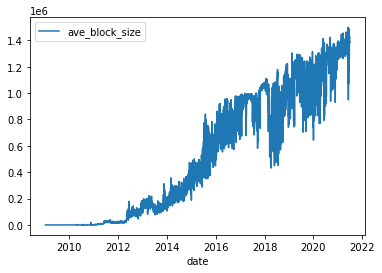

In [460]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
ave_block_size.rename({'value' : 'ave_block_size'}, axis=1, inplace=True)
ave_block_size = convert_timestamp(ave_block_size)
ave_block_size.plot(kind='line', x='date', y='ave_block_size')

## Hash Rate

In [461]:
# import hash rate data and rough analysis
hash_rate = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\hash-rate.csv')
initial_stats(hash_rate)

              timestamp         value
0  2009-01-09T00:00:00Z  1.281850e+05
1  2009-01-10T00:00:00Z  1.676938e+06
2  2009-01-11T00:00:00Z  4.679436e+06
3  2009-01-12T00:00:00Z  4.653054e+06
4  2009-01-13T00:00:00Z  6.070590e+06 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   2.443487e+19
std    4.469488e+19
min    1.281850e+05
25%    1.150495e+13
50%    3.306241e+17
75%    3.124441e+19
max    1.978909e+20

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

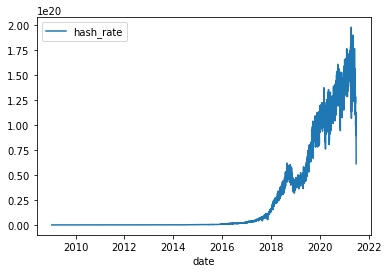

In [462]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
hash_rate.rename({'value':'hash_rate'}, axis=1, inplace=True)
hash_rate = convert_timestamp(hash_rate)
hash_rate.plot(kind='line', x='date', y='hash_rate')

## Difficulty

In [463]:
# import average block size data and rough analysis
difficulty = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\difficulty.csv')
initial_stats(difficulty)

              timestamp         value
0  2009-01-09T00:00:00Z  4.294967e+09
1  2009-01-10T00:00:00Z  4.294967e+09
2  2009-01-11T00:00:00Z  4.294967e+09
3  2009-01-12T00:00:00Z  4.294967e+09
4  2009-01-13T00:00:00Z  4.294967e+09 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   1.457148e+22
std    2.677179e+22
min    4.294967e+09
25%    6.833615e+15
50%    2.036998e+20
75%    1.779782e+22
max    1.075738e+23

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

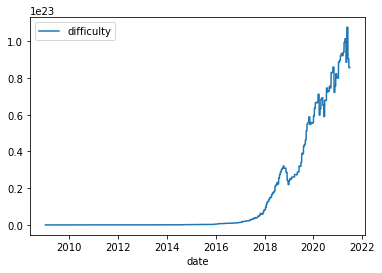

In [464]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
difficulty.rename({'value':'difficulty'}, axis=1, inplace=True)
difficulty = convert_timestamp(difficulty)
difficulty.plot(kind='line', x='date', y='difficulty')

## Block Height

In [465]:
# import average block height data and rough analysis
block_height = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\block-height.csv')

<AxesSubplot:xlabel='date'>

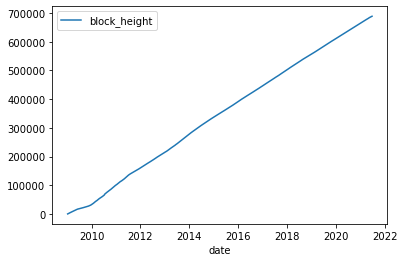

In [466]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
block_height.rename({'value':'block_height'}, axis=1, inplace=True)
block_height = convert_timestamp(block_height)
block_height.plot(kind='line', x='date', y='block_height')

## Transaction Rate

In [467]:
# import transaction rate data and rough analysis
transaction_rate = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\transaction-rate.csv')
initial_stats(transaction_rate)

              timestamp  value
0  2009-01-03T00:00:00Z    0.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

             value
count  4559.000000
mean      1.653451
std       1.476095
min       0.000000
25%       0.092130
50%       1.165127
75%       3.067442
max       5.676609

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

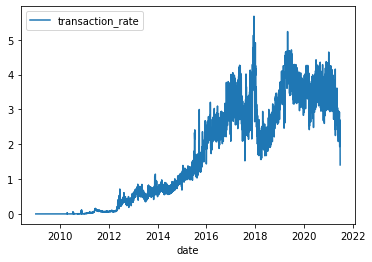

In [468]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
transaction_rate.rename({'value':'transaction_rate'}, axis=1, inplace=True)
transaction_rate = convert_timestamp(transaction_rate)
transaction_rate.plot(kind='line', x='date', y='transaction_rate')

In [469]:
# create 7 day moving average for the change in transaction rate
transaction_rate['7dMA_transaction_rate'] = transaction_rate['transaction_rate'].rolling(window=7).mean()
transaction_rate.head(14)

# create one-day change for transaction rate moving average
transaction_rate_df = add_change_col(transaction_rate, 2)

transaction_rate_df.head(14)


,transaction_rate,date,7dMA_transaction_rate,7dMA_transaction_rate_change
0,0.000000,2009-01-03,NaN,0.000000
1,0.000000,2009-01-04,NaN,NaN
2,0.000000,2009-01-05,NaN,NaN
3,0.000000,2009-01-06,NaN,NaN
4,0.000000,2009-01-07,NaN,NaN
5,0.000000,2009-01-08,NaN,NaN
6,0.000000,2009-01-09,0.000000,NaN
7,0.000000,2009-01-10,0.000000,NaN
8,0.000000,2009-01-11,0.000000,NaN
9,0.000081,2009-01-12,0.000012,inf


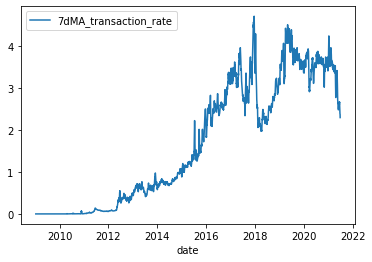

In [470]:
# plot the 20_day_MA of transaction rate
transaction_rate_df.plot(kind='line', x='date', y='7dMA_transaction_rate')
plt.show()

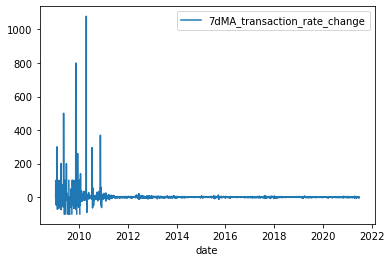

In [471]:
transaction_rate_df.plot(kind='line', x='date', y='7dMA_transaction_rate_change')
plt.show()

## Exchange Balance

In [472]:
# import exchange balance data and rough analysis
exchange_balance = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\exchange-balance.csv')
initial_stats(exchange_balance)

              timestamp      value
0  2011-08-17T00:00:00Z   0.007500
1  2011-08-18T00:00:00Z   8.056529
2  2011-08-19T00:00:00Z  47.647947
3  2011-08-20T00:00:00Z  39.599918
4  2011-08-21T00:00:00Z  41.418918 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

              value
count  3.603000e+03
mean   1.302041e+06
std    1.087909e+06
min    7.500000e-03
25%    3.343947e+05
50%    9.835482e+05
75%    2.499679e+06
max    3.056155e+06

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

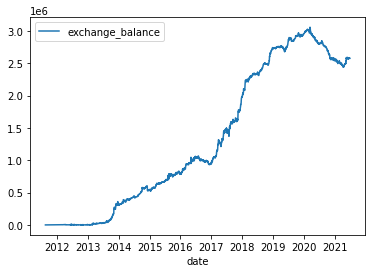

In [473]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_balance.rename({'value':'exchange_balance'}, axis=1, inplace=True)
exchange_balance = convert_timestamp(exchange_balance)
exchange_balance.plot(kind='line', x='date', y='exchange_balance')

## Exchange Withdrawals

In [474]:
# import exchange withdrawal and rough analysis
exchange_withdrawals = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\exchange-withdrawals.csv')
initial_stats(exchange_withdrawals)

              timestamp  value
0  2011-08-17T00:00:00Z      0
1  2011-08-18T00:00:00Z      1
2  2011-08-19T00:00:00Z      0
3  2011-08-20T00:00:00Z      2
4  2011-08-21T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

               value
count    3603.000000
mean    21635.385512
std     20202.222225
min         0.000000
25%      2031.500000
50%     20436.000000
75%     35132.000000
max    107104.000000

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

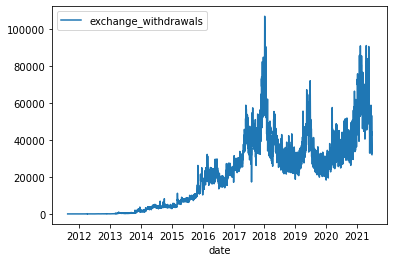

In [475]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_withdrawals.rename({'value':'exchange_withdrawals'}, axis=1, inplace=True)
exchange_withdrawals = convert_timestamp(exchange_withdrawals)
exchange_withdrawals.plot(kind='line', x='date', y='exchange_withdrawals')

## Exchange Deposits

In [476]:
# import exchange deposits data and rough analysis
exchange_deposits = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\exchange-deposits.csv')
initial_stats(exchange_deposits)

              timestamp  value
0  2011-08-17T00:00:00Z      1
1  2011-08-18T00:00:00Z      3
2  2011-08-19T00:00:00Z      4
3  2011-08-20T00:00:00Z      1
4  2011-08-21T00:00:00Z      2 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

               value
count    3603.000000
mean    28309.417152
std     28705.293135
min         0.000000
25%      2992.000000
50%     25977.000000
75%     45152.000000
max    272008.000000

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

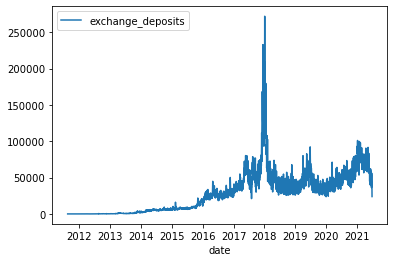

In [477]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_deposits.rename({'value':'exchange_deposits'}, axis=1, inplace=True)
exchange_deposits = convert_timestamp(exchange_deposits)
exchange_deposits.plot(kind='line', x='date', y='exchange_deposits')

## Miners Inflow Volume

In [478]:
# import miner inflow volume data and rough analysis
miner_inflow_vol = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\miner-inflow-volume.csv')
initial_stats(miner_inflow_vol)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

              value
count   4194.000000
mean    5532.124337
std     3975.044015
min        0.000000
25%     2415.495661
50%     4585.570653
75%     7603.450304
max    54968.693709

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

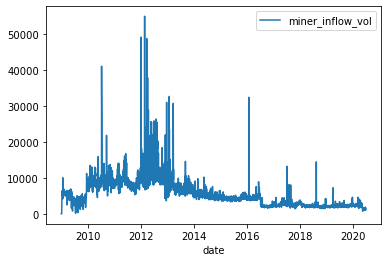

In [479]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_inflow_vol.rename({'value':'miner_inflow_vol'}, axis=1, inplace=True)
miner_inflow_vol = convert_timestamp(miner_inflow_vol)
miner_inflow_vol.plot(kind='line', x='date', y='miner_inflow_vol')

## Miner Outflow Volume

In [480]:
# import miner outflow volume data and rough analysis
miner_outflow_vol = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\miner-outflow-volume.csv')
initial_stats(miner_outflow_vol)

              timestamp  value
0  2009-01-03T00:00:00Z    0.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

               value
count    4194.000000
mean     5098.490854
std      6331.576099
min         0.000000
25%      2051.547892
50%      3531.400796
75%      6998.152541
max    165845.314780

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

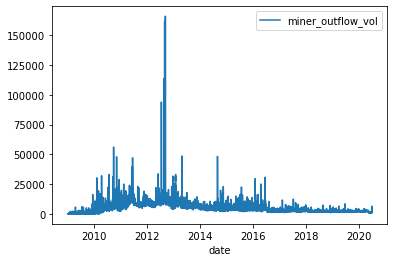

In [481]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_outflow_vol.rename({'value':'miner_outflow_vol'}, axis=1, inplace=True)
miner_outflow_vol = convert_timestamp(miner_outflow_vol)
miner_outflow_vol.plot(kind='line', x='date', y='miner_outflow_vol')

## Miners Revenue

In [482]:
# import miner revenue data and rough analysis
miner_revenue = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\miner-revenue-total.csv')
initial_stats(miner_revenue)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count   4559.000000
mean    4166.443354
std     2838.558190
min        0.000000
25%     1958.139072
50%     3669.353087
75%     5750.000000
max    34600.000000

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

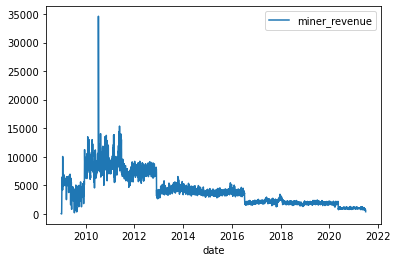

In [483]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_revenue.rename({'value':'miner_revenue'}, axis=1, inplace=True)
miner_revenue = convert_timestamp(miner_revenue)
miner_revenue.plot(kind='line', x='date', y='miner_revenue')

## Miner Balance

In [484]:
# import miner balance data and rough analysis
miner_balance = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\miner-balance.csv')
initial_stats(miner_balance)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z   50.0
2  2009-01-05T00:00:00Z   50.0
3  2009-01-06T00:00:00Z   50.0
4  2009-01-07T00:00:00Z   50.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

              value
count  4.194000e+03
mean   1.924503e+06
std    4.335630e+05
min    5.000000e+01
25%    1.814936e+06
50%    1.942826e+06
75%    2.092134e+06
max    2.697960e+06

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

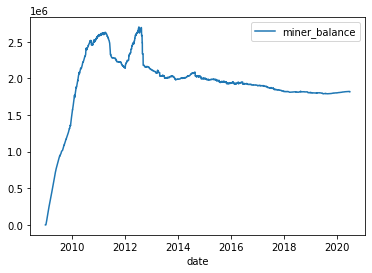

In [485]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_balance.rename({'value':'miner_balance'}, axis=1, inplace=True)
miner_balance = convert_timestamp(miner_balance)
miner_balance.plot(kind='line', x='date', y='miner_balance')

###  It may be better if it only uses the September 2011 and newer data.

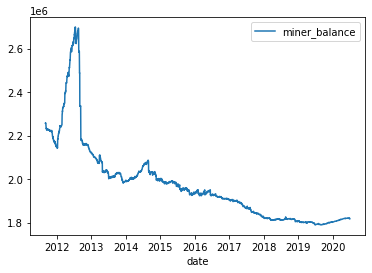

In [486]:
miner_balance[miner_balance['date'] > dt.date(2011, 9, 1)].plot(kind='line', x='date', y='miner_balance')
plt.show()


### This certainly looks more relevant and range bound. 1-1-2013 seems to be a better cut-off date, certainly for this set of data

## Miner to Exchange

In [487]:
# import miner_to_exchanges data and rough analysis
miner_to_exchanges = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\miners-to-exchanges.csv')
initial_stats(miner_to_exchanges)

              timestamp     value
0  2011-08-18T00:00:00Z  7.082432
1  2011-08-19T00:00:00Z  0.000000
2  2011-08-20T00:00:00Z  0.000000
3  2011-08-21T00:00:00Z  0.000000
4  2011-08-22T00:00:00Z  0.000000 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3237, 2) 

              value
count   3237.000000
mean     262.920725
std      608.411862
min        0.000000
25%       73.597261
50%      152.005978
75%      276.614734
max    17961.386845

Date range is: 2011-08-18T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

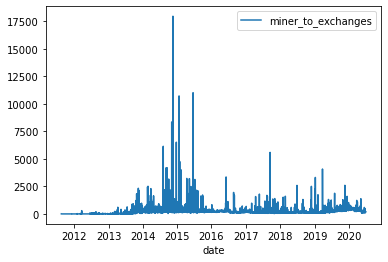

In [488]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_to_exchanges.rename({'value':'miner_to_exchanges'}, axis=1, inplace=True)
miner_to_exchanges = convert_timestamp(miner_to_exchanges)
miner_to_exchanges.plot(kind='line', x='date', y='miner_to_exchanges')

## Total Addresses

In [489]:
# import total addresses and rough analysis
total_addresses = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\total-addresses.csv')
initial_stats(total_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   2.076464e+08
std    2.534553e+08
min    1.000000e+00
25%    3.076182e+06
50%    7.033741e+07
75%    3.967795e+08
max    8.468340e+08

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

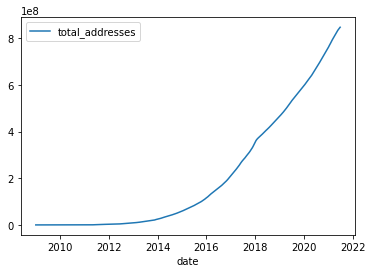

In [490]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
total_addresses.rename({'value':'total_addresses'}, axis=1, inplace=True)
total_addresses = convert_timestamp(total_addresses)
total_addresses.plot(kind='line', x='date', y='total_addresses')

## Daily Active Addresses

In [491]:
# import active addresses data and rough analysis
daily_active_addresses = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\active-addresses.csv')
initial_stats(daily_active_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      0
1  2009-01-04T00:00:00Z      0
2  2009-01-05T00:00:00Z      0
3  2009-01-06T00:00:00Z      0
4  2009-01-07T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   3.753300e+05
std    3.621253e+05
min    0.000000e+00
25%    1.961700e+04
50%    2.570070e+05
75%    6.786685e+05
max    1.362772e+06

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

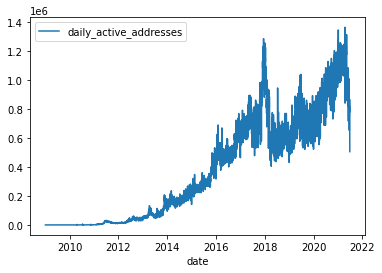

In [492]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
daily_active_addresses.rename({'value':'daily_active_addresses'}, axis=1, inplace=True)
daily_active_addresses = convert_timestamp(daily_active_addresses)
daily_active_addresses.plot(kind='line', x='date', y='daily_active_addresses')


## Balance of Addresses

### Addresses > 1 BTC

In [493]:
# import address data > 1 btc and rough analysis
over_onebtc_addresses = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\addresses-with-balance-≥-1.csv')
initial_stats(over_onebtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

               value
count    4563.000000
mean   398836.537804
std    285581.628114
min         1.000000
25%    125735.000000
50%    370736.000000
75%    704790.000000
max    830579.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

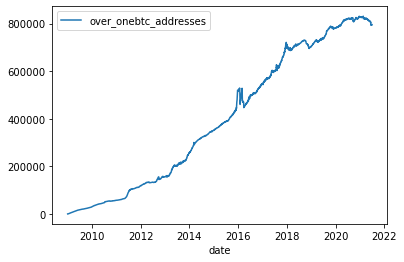

In [494]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_onebtc_addresses.rename({'value':'over_onebtc_addresses'}, axis=1, inplace=True)
over_onebtc_addresses = convert_timestamp(over_onebtc_addresses)
over_onebtc_addresses.plot(kind='line', x='date', y='over_onebtc_addresses')

### Addresses > 10 BTC

In [495]:
# import address data > 10 btc and rough analysis
over_tenbtc_addresses = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\addresses-with-balance-≥-10.csv')
initial_stats(over_tenbtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

               value
count    4563.000000
mean   108562.720359
std     45095.458054
min         1.000000
25%     74897.500000
50%    123389.000000
75%    149086.000000
max    157275.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

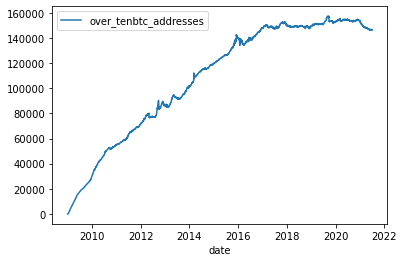

In [496]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_tenbtc_addresses.rename({'value':'over_tenbtc_addresses'}, axis=1, inplace=True)
over_tenbtc_addresses = convert_timestamp(over_tenbtc_addresses)
over_tenbtc_addresses.plot(kind='line', x='date', y='over_tenbtc_addresses')


### Addresses over 100 BTC

In [497]:
# import address data > 100 btc and rough analysis
over_onehunbtc_addresses = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\addresses-with-balance-≥-100.csv')
initial_stats(over_onehunbtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      0
1  2009-01-04T00:00:00Z      0
2  2009-01-05T00:00:00Z      0
3  2009-01-06T00:00:00Z      0
4  2009-01-07T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

              value
count   4563.000000
mean   11910.002411
std     6498.374129
min        0.000000
25%     7697.000000
50%    16001.000000
75%    16587.500000
max    18543.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

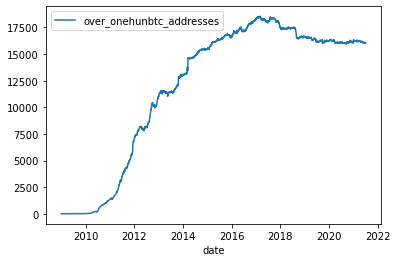

In [498]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_onehunbtc_addresses.rename({'value':'over_onehunbtc_addresses'}, axis=1, inplace=True)
over_onehunbtc_addresses = convert_timestamp(over_onehunbtc_addresses)
over_onehunbtc_addresses.plot(kind='line', x='date', y='over_onehunbtc_addresses')

## UTXO

In [499]:
# import UTXO data and rough analysis
utxo = pd.read_csv(r'C:\Users\dagar\Bitcoin_Deep_Learning\utx-os-total.csv')
initial_stats(utxo)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   3.615384e+07
std    3.918749e+07
min    1.000000e+00
25%    1.337852e+06
50%    1.814996e+07
75%    5.701335e+07
max    1.252068e+08

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

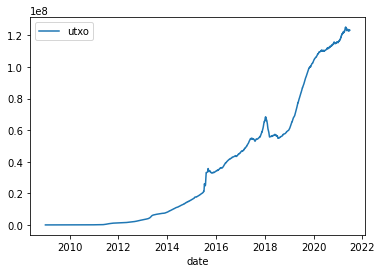

In [500]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
utxo.rename({'value':'utxo'}, axis=1, inplace=True)
utxo = convert_timestamp(utxo)
utxo.plot(kind='line', x='date', y='utxo')

## Check the list of df names and remove the miner data that does not have data past 2020

Dataframes miner_inflow_vol, miner_outflow_vol, miner_balance, miner_to_exchanges only have data up to date 06-27-2020 and therefor are missing relevant recent data. These dataframes will be dropped and not used in the model.

In [501]:
# view the name of the different dataframes in the full list of dataframes aggregated
df_names_list = [df.columns[0] for df in df_list]
print(df_names_list)

['price', 'ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_inflow_vol', 'miner_outflow_vol', 'miner_revenue', 'miner_balance', 'miner_to_exchanges', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo']


In [502]:
# drop miner names from list, except for miner_revenue
drop_list = ['miner_inflow_vol', 'miner_outflow_vol', 'miner_balance', 'miner_to_exchanges']

# create a new list of df without the drop_list dfs
df_new_list = []

for df in df_list:
    if df.columns[0] not in drop_list:
        df_new_list.append(df)
        
[df.columns[0] for df in df_new_list]

['price',
 'ave_block_size',
 'hash_rate',
 'difficulty',
 'block_height',
 'transaction_rate',
 'exchange_balance',
 'exchange_withdrawals',
 'exchange_deposits',
 'miner_revenue',
 'total_addresses',
 'daily_active_addresses',
 'over_onebtc_addresses',
 'over_tenbtc_addresses',
 'over_onehunbtc_addresses',
 'utxo']

### Date Range to use for combining the data

Based on the exploratory data analysis. The date range looks like it should start at January of 2013 and go to current.

### Create single dataframe joined on the date column with only the data between 01-01-2013 and 06-11-2021

Since I will not be including most of the miner data, I can now use up to 6-11-2021 which is the price date range end

In [503]:
# create the final df using the price df and merge the rest and have price be the last column
def date_bool(df):
    return df[(df['date'] >= dt.date(2013, 1, 1)) & (df['date'] <= dt.date(2021, 6, 11))]
                                              
# create a new df with the various price targets in the new date range
btc_final = date_bool(price)

# loop through the df list and add them to the btc_final df
for df in df_new_list[1:]:
    df = date_bool(df)
    btc_final = pd.merge(btc_final, df, on='date', how='inner')

In [504]:
btc_final.columns

Index(['price', 'date', '1_day_change', '1_day', '3_day', '7_day', '30_day',
       '90_day', '180_day', 'ave_block_size', 'hash_rate', 'difficulty',
       'block_height', 'transaction_rate', '7dMA_transaction_rate',
       '7dMA_transaction_rate_change', 'exchange_balance',
       'exchange_withdrawals', 'exchange_deposits', 'miner_revenue',
       'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo'],
      dtype='object')

### Create new dataframes for the various different predictions.

Create a new dataframe for the target 1_day, 7_day, 30_day, 90_day, and 180_day. This will allow features to be revealed that are specific for short term prediction as well as the features that are specific for the long term predictions. 

In [505]:
# create a function to process the dataframe and create desired new ones
def create_dataframe(df, col_name):
    date_df = df[['date']]
    target = df[[col_name]]
    column_names = ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 
                    'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses',
                   'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo']
    features = df.loc[:, column_names]
    new_df = pd.concat([date_df, features, target], axis=1)
    return new_df
    

In [506]:
btc_final.head()

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day,ave_block_size,...,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
0,13.220,2013-01-01,-1.406959,13.034,13.174,13.20,19.450000,96.149146,88.980000,89114.771605,...,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297
1,13.034,2013-01-02,1.196870,13.190,13.150,13.50,20.460000,104.706000,89.483037,114158.385621,...,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506
2,13.190,2013-01-03,-0.121304,13.174,13.150,13.58,20.363143,115.803182,83.866380,108105.271605,...,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036
3,13.174,2013-01-04,-0.182177,13.150,13.200,14.00,19.821210,132.545678,87.920276,141893.150327,...,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340
4,13.150,2013-01-05,0.000000,13.150,13.500,14.00,20.296000,134.940325,77.870028,118321.985816,...,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604


In [507]:
# create the new dataframes with the specific targets of interest and remove the data that is out of the prediction range

df_1_day = create_dataframe(btc_final.iloc[:-1, :], '1_day')
df_3_day = create_dataframe(btc_final.iloc[:-3, :], '3_day')
df_7_day = create_dataframe(btc_final.iloc[:-7, :], '7_day')
df_30_day = create_dataframe(btc_final.iloc[:-30, :], '30_day')
df_90_day = create_dataframe(btc_final.iloc[:-90, :], '90_day')
df_180_day = create_dataframe(btc_final.iloc[:-180, :], '180_day')
df_1_day_change = create_dataframe(btc_final.iloc[:-1, :], '1_day_change')




In [508]:
df_180_day.tail()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,180_day
2899,2020-12-09,1.275818e+06,1.323202e+20,8.227935e+22,660695,3.714583,2.553090e+06,47901,61778,941.207294,748309692,1058484,824225,153996,16135,115338499,35797.422390
2900,2020-12-10,1.306711e+06,1.239075e+20,8.227935e+22,660825,3.628692,2.547062e+06,50015,57602,885.332869,748822558,993039,825050,154177,16125,115462581,33577.694225
2901,2020-12-11,1.325937e+06,1.320266e+20,8.227935e+22,660963,3.525428,2.552486e+06,46887,59922,932.996300,749330847,1075098,825602,154275,16120,115504066,33452.002255
2902,2020-12-12,1.296116e+06,1.273510e+20,8.227935e+22,661095,3.417569,2.557838e+06,42219,53653,875.588359,749813135,963457,826043,154300,16114,115531445,37290.991776
2903,2020-12-13,1.174224e+06,1.474404e+20,8.018776e+22,661251,3.194491,2.565131e+06,34454,51169,1014.241547,750262804,943850,826438,154356,16100,115419484,36744.739308


In [509]:
df_1_day_change.tail()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,1_day_change
3078,2021-06-06,9.487188e+05,1.567872e+20,9.039931e+22,686585,2.142998,2.580070e+06,33378,39821,960.078926,839134321,715945,808124,146322,16053,122948229,-6.200804
3079,2021-06-07,1.250725e+06,1.391161e+20,9.039931e+22,686718,2.723912,2.575684e+06,47350,55663,865.806271,839539074,907287,804696,146239,16070,122937997,-0.374332
3080,2021-06-08,1.286349e+06,1.556879e+20,9.039931e+22,686867,2.855984,2.571881e+06,55598,59802,966.497220,839961397,1002115,804479,146216,16072,122886946,11.476113
3081,2021-06-09,1.067569e+06,1.325858e+20,9.039931e+22,686993,2.439641,2.563289e+06,53364,50795,820.838852,840332902,815580,805686,146421,16094,123024545,-1.464838
3082,2021-06-10,1.311452e+06,1.229894e+20,9.039931e+22,687111,2.926678,2.575089e+06,53425,61884,783.871333,840762910,942997,805207,146457,16089,123139296,0.066088


## Prepare Data For Prediction Model

### Normalize the features of the dataframe using MinMaxScaler

This uses the following formula to create the data values to between 0 and 1:
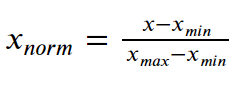

In [510]:
df_1_day.head()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,1_day
0,2013-01-01,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297,13.034
1,2013-01-02,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506,13.190
2,2013-01-03,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036,13.174
3,2013-01-04,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340,13.150
4,2013-01-05,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604,13.150


In [511]:
# set the index to be the date
df_1_day.set_index('date', inplace=True)

In [512]:
from sklearn.preprocessing import MinMaxScaler

# create the min max scaler object
scaler = MinMaxScaler()

# all the columns except the last one of price
cols = df_1_day.columns[:-1]

# normalize the features
feat_1_day = pd.DataFrame(scaler.fit_transform(df_1_day.iloc[:, :-1]),
              columns=cols, index=df_1_day.index) 

feat_1_day.head()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2013-01-01,0.009112,2.867282e-08,4.336451e-10,0.000000,0.003398,0.000731,0.000075,0.000140,0.578680,0.000000,0.000000,0.001460,0.020764,0.005586,0.000000
2013-01-02,0.026710,2.335443e-08,4.336451e-10,0.000324,0.019792,0.000930,0.000233,0.000246,0.541335,0.000029,0.004021,0.001866,0.022516,0.000000,0.000125
2013-01-03,0.022457,2.963301e-08,4.336451e-10,0.000667,0.026021,0.000814,0.000168,0.000132,0.580777,0.000065,0.010160,0.002044,0.023358,0.004123,0.000244
2013-01-04,0.046200,2.190495e-08,4.336451e-10,0.000991,0.039684,0.000811,0.000346,0.000776,0.542435,0.000096,0.007202,0.001854,0.020916,0.009842,0.000328
2013-01-05,0.029636,1.399982e-08,4.336451e-10,0.001289,0.020172,0.001042,0.000168,0.000526,0.489899,0.000129,0.011873,0.001530,0.016239,0.016359,0.000462


## Linear Regression Model for 1 Day Price

### Run a polynomial regression model on the normalized features and the 1 day price

### ---------Remove out bottom 30 days worth of data and use for final validation prediction-----------------------

In [513]:
# create a small dataframe of 30 values to exclude that will act as the prediction test
X_final_test = feat_1_day.iloc[-30:, :]
y_final_test = df_1_day.iloc[-30:, -1]

In [514]:
X_final_test.tail()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2021-06-06,0.613176,0.792291,0.840347,0.998887,0.336712,0.844203,0.311416,0.145888,0.045825,0.998043,0.511901,0.966745,0.848887,0.668839,0.981481
2021-06-07,0.825402,0.702994,0.840347,0.999168,0.445755,0.842768,0.441911,0.204163,0.029700,0.998529,0.656289,0.961668,0.847742,0.671100,0.981397
2021-06-08,0.850436,0.786736,0.840347,0.999483,0.470546,0.841524,0.518946,0.219389,0.046923,0.999037,0.727846,0.961346,0.847424,0.671366,0.980979
2021-06-09,0.696695,0.669994,0.840347,0.999750,0.392395,0.838712,0.498081,0.186256,0.022009,0.999483,0.587086,0.963134,0.850252,0.674292,0.982107
2021-06-10,0.868077,0.621501,0.840347,1.000000,0.483816,0.842573,0.498650,0.227048,0.015686,1.000000,0.683236,0.962425,0.850749,0.673627,0.983048


In [515]:
# create separate arrays for the features and the 1 day price
X = feat_1_day.iloc[:-30, :]
y = df_1_day.iloc[:-30, -1]

# compare the shape of the new df with the last 30 days excluded
print(X.shape, y.shape)
# compared to the old df with all the data
print(feat_1_day.shape, df_1_day.shape)

(3053, 15) (3053,)
(3083, 15) (3083, 16)


In [516]:
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# split the data to train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=5)

def polynomial_reg(X_train, X_test, y_train, y_test, deg_start, deg_end):
    #create variable to updated through iterations
    max_test_r2 = 0
    
    # loop through polynomial degress of 1 to 4
    for deg in range(deg_start, deg_end+1):
    
        polynomial_features = PolynomialFeatures(degree = deg)

        X_TRANSF = polynomial_features.fit_transform(X_train)
    

    # #----------------------------------------------------------------------------------------#
    # # Step 3: define and train a model

        model = LinearRegression()

        model.fit(X_TRANSF, y_train)
    
    

    # #----------------------------------------------------------------------------------------#
    # # Step 4: calculate bias and variance
        predict_poly = polynomial_features.fit_transform(X_train)
    
        Y_NEW = model.predict(predict_poly)
   
        train_rmse = np.sqrt(mean_squared_error(y_train, Y_NEW))
        train_r2 = r2_score(y_train, Y_NEW)

        print('Degree: ', deg)
        print('Train RMSE: ', train_rmse)
        print('Train R2: ', train_r2)
    
        predict_poly = polynomial_features.fit_transform(X_test)
    
        Y_NEW = model.predict(predict_poly)
   
        test_rmse = np.sqrt(mean_squared_error(y_test, Y_NEW))
        test_r2 = r2_score(y_test, Y_NEW)
        
        # keep the highest performing test r2 results:
        if test_r2 > max_test_r2:
            max_deg, max_train_rmse, max_train_r2, max_test_rmse, max_test_r2 = \
                    deg, train_rmse, train_r2, test_rmse, test_r2 

        print('Test RMSE: ', test_rmse)
        print('Test R2: ', test_r2, '\n\n')
        
    # print the best results
    print('---------------------------------------')
    print('Best Results are:')
    print('Degree: ', max_deg)
    print('Train RMSE: ', max_train_rmse)
    print('Train R2: ', max_train_r2 )
    print('Test RMSE: ', max_test_rmse)
    print('Test R2: ', max_test_r2)

print(X_train.shape, y_train.shape)
polynomial_reg(X_train, X_test, y_train, y_test, 1, 4)    

(2137, 15) (2137,)
Degree:  1
Train RMSE:  3704.6965439215223
Train R2:  0.8626690652231034
Test RMSE:  4099.3303517951845
Test R2:  0.870427597376513 


Degree:  2
Train RMSE:  1054.013450637476
Train R2:  0.9888838243135613
Test RMSE:  1236.3113523714287
Test R2:  0.9882146525718202 


Degree:  3
Train RMSE:  359.55696291993337
Train R2:  0.9987064044806946
Test RMSE:  2107.232737112776
Test R2:  0.9657617400458604 


Degree:  4
Train RMSE:  3.4581666953769413e-07
Train R2:  1.0
Test RMSE:  7384.615934194598
Test R2:  0.5795227514258485 


---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1054.013450637476
Train R2:  0.9888838243135613
Test RMSE:  1236.3113523714287
Test R2:  0.9882146525718202


## Linear Regression Training and Testing Results:

The best results for this data is with the **polynomial degree of 2** since it has the lowest root mean squared error and has the highest R-squared for the test data set.

Once the polynomial degree is greater than 2, there is overfitting, which can be observed from the fact that the training data results get better while the testing data results get worse.

The best test R2 results are 0.9877 for one day price prediction

## One Day Prediction Test

In [517]:
# Make a prediction on the final 30 days of the dataframe

# create polynomial model and train model
polynomial_features = PolynomialFeatures(degree = 2)
X_TRANSF = polynomial_features.fit_transform(X_train)
model = LinearRegression()
model.fit(X_TRANSF, y_train)



# use model to predict 1-day price
predict_poly = polynomial_features.fit_transform(X_final_test)    


Y_pred_final = model.predict(predict_poly)


In [518]:
# create a df using the actual 1-day values and the predicted values
y_final_test = pd.DataFrame(y_final_test)
y_final_test['Predicted_price'] = Y_pred_final
y_final_test.head()

,1_day,Predicted_price
date,,
2021-05-12,49729.302500,57771.564865
2021-05-13,49873.686392,55308.314478
2021-05-14,46803.830522,54901.002515
2021-05-15,46406.331544,52816.091152
2021-05-16,43382.147859,53773.278155


In [519]:
y_final_test = y_final_test.reset_index()
y_final_test.head()

,date,1_day,Predicted_price
0,2021-05-12,49729.302500,57771.564865
1,2021-05-13,49873.686392,55308.314478
2,2021-05-14,46803.830522,54901.002515
3,2021-05-15,46406.331544,52816.091152
4,2021-05-16,43382.147859,53773.278155


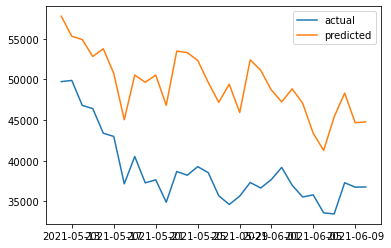

In [520]:
fig, ax = plt.subplots()

ax.plot(y_final_test['date'], y_final_test['1_day'], label='actual')
ax.plot(y_final_test['date'], y_final_test['Predicted_price'], label='predicted')
plt.legend()
plt.show()

The predicted values are larger in value that the actual, but the change in price or the direction of price movement is very similar. That is a very encouraging sign.

Let's look at the root mean squared error and the R-squared.

In [521]:
test_rmse = np.sqrt(mean_squared_error(y_final_test['1_day'], y_final_test['Predicted_price']))
test_r2 = r2_score(y_final_test['1_day'], y_final_test['Predicted_price'])
print('RMSE:', test_rmse)
print('R-squared:', test_r2)

RMSE: 10950.970431792288
R-squared: -5.392942039259607


In [522]:
# create a new dataframe with the predicted values
predicted_final = pd.DataFrame(y_final_test[['date', 'Predicted_price']])
predicted_final.set_index('date', inplace=True)

predicted_final.rename(columns={'Predicted_price':'1_day_pred'}, inplace=True)

predicted_final.head()

,1_day_pred
date,
2021-05-12,57771.564865
2021-05-13,55308.314478
2021-05-14,54901.002515
2021-05-15,52816.091152
2021-05-16,53773.278155


## Predict 180 day price

One day price prediction model had very good R-squared and while the actual value for the validated sample data was not accurate, the direction in price change was quite accurate. Let's whether current on-chain data can accurately predict price for 180 days later.

### Normalize the values

In [523]:
# create a normalization and datframe split function

def preprocess_data(df):
    # instantiate normalizer
    scaler = MinMaxScaler()
    
    # create df of only the feature columns, exclude price
    feat_df = df.iloc[:, :-1]
    
    # normalize the features
    feat_df = pd.DataFrame(scaler.fit_transform(feat_df),
                          columns=feat_df.columns, index=feat_df.index)
    
    # create the price df
    price_df = pd.DataFrame(df.iloc[:, -1])
    
    return feat_df, price_df
    

In [524]:
# Make a prediction on the final 30 days of the dataframe to be a validation set

# create polynomial model and train model
def linear_predict(features, target, deg=2):
    # separate the bottom 30 rows into the validation sample
    X_val = features.iloc[-30: , :]
    y_val = target.iloc[-30: , : ]
    
    # create the training data from the rest of the data
    X_train = features.iloc[:-30, : ]
    y_train = target.iloc[:-30, : ]
    
    #randomly split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state=5)
    
    # use a polynomial model of 2 degrees default to avoid overfitting
    polynomial_features = PolynomialFeatures(degree = deg)
    X_TRANSF = polynomial_features.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_TRANSF, y_train)
    
    predict_poly = polynomial_features.fit_transform(X_train)
    
    Y_NEW = model.predict(predict_poly)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, Y_NEW))
    train_r2 = r2_score(y_train, Y_NEW)

    print('Degree:', deg)
    print('Train RMSE: ', train_rmse)
    print('Train R2: ', train_r2)

    # use model to predict future price
    predict_poly = polynomial_features.fit_transform(X_test)    

    # generate predictions for test data
    y_test_final = model.predict(predict_poly)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_final))
    test_r2 = r2_score(y_test, y_test_final)
    
    print('Test RMSE: ', test_rmse)
    print('Test R2: ', test_r2, '\n\n')
    
    # use model to predict future price of final 30 values for validation
    predict_poly = polynomial_features.fit_transform(X_val)
    
    y_val_final = model.predict(predict_poly)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_final))
    val_r2 = r2_score(y_val, y_val_final)
    
    print('Validation RMSE: ', val_rmse)
    print('Validation R2: ', val_r2, '\n\n')
    
    
    return y_val_final, y_val


In [525]:
# create a function to plot predictions and return a dataframe
def plot_predictions(y_preds, y_test, plot_title):
    y_df = pd.DataFrame(y_test)
    y_df['predictions'] = y_preds
    y_df = y_df.reset_index()
    
    plt.plot(y_df.iloc[:, 0], y_df.iloc[:, 1], label='actual')
    plt.plot(y_df.iloc[:, 0], y_df.iloc[:, 2], label='prediction')
    plt.legend()
    plt.title(plot_title)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return y_df

## 180 Day Price Predictions

In [526]:
df_180_day.set_index('date', inplace=True)

# preprocess and split the features from the price data
feat_180_day, price_180_day = preprocess_data(df_180_day)

In [527]:
# create a prediction model
y_pred_final, y_test = linear_predict(feat_180_day, price_180_day, deg=2)

Degree: 2
Train RMSE:  1296.6282413085069
Train R2:  0.9841236809760968
Test RMSE:  1455.100431596834
Test R2:  0.9835914625996837 


Validation RMSE:  27720.96291513268
Validation R2:  -33.089241898423964 




### The results on the test data are not very good. Let's look at the plot.

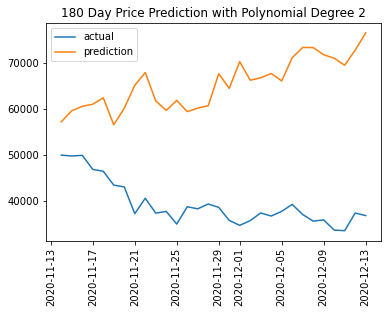

In [528]:
df_180_pred = plot_predictions(y_pred_final, y_test, '180 Day Price Prediction with Polynomial Degree 2')

#### Compare to 1 degree polynomial and 3 degree polynomial for the 180 day price data

In [529]:
# create a prediction model with degree 1
y_pred_final, y_test = linear_predict(feat_180_day, price_180_day, deg=1)

Degree: 1
Train RMSE:  3750.088909350428
Train R2:  0.8671988020076896
Test RMSE:  3957.3727206070666
Test R2:  0.8786337750283023 


Validation RMSE:  19015.387849028688
Validation R2:  -15.04024861782094 




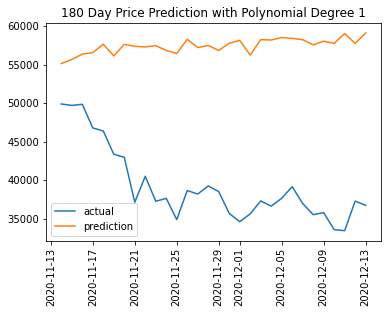

In [530]:
df_180_pred = plot_predictions(y_pred_final, y_test, '180 Day Price Prediction with Polynomial Degree 1')

In [531]:
# create a prediction model
y_pred_final, y_test = linear_predict(feat_180_day, price_180_day, deg=3)

Degree: 3
Train RMSE:  427.44772369999663
Train R2:  0.9982746195158987
Test RMSE:  1598.960058611036
Test R2:  0.9801865928983247 


Validation RMSE:  17534.26648120428
Validation R2:  -12.638792578671104 




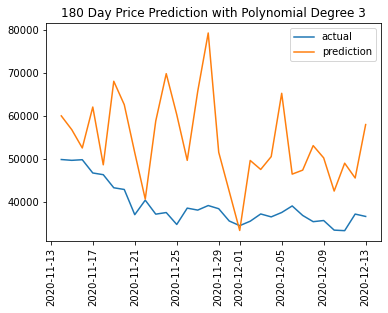

In [532]:
df_180_pred = plot_predictions(y_pred_final, y_test, '180 Day Price Prediction with Polynomial Degree 3')

In [533]:
# create a prediction model
y_pred_final, y_test = linear_predict(feat_180_day, price_180_day, deg=4)

Degree: 4
Train RMSE:  7.247111677150463e-07
Train R2:  1.0
Test RMSE:  13518.090719225444
Test R2:  -0.4161675720314244 


Validation RMSE:  56158.55404988581
Validation R2:  -138.90478032211823 




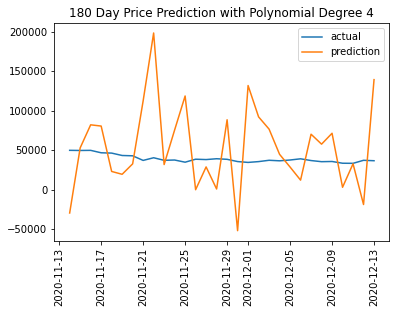

In [534]:
df_180_pred = plot_predictions(y_pred_final, y_test, '180 Day Price Prediction with Polynomial Degree 4')

## Analyis of 180 day price prediction:
Current on-chain analytics are not sufficient for determining the price 180 days later. There was not a polynomial degree that could match the predicted data closely to the actual data. The R-squared values were not strong for the test data. As well, the change of direction of price change does not mimic the actual test data. 

**This model will not work for 180 day price prediction**

## 7 Day Price Prediction

In [535]:
# convert the index to date values
df_7_day.set_index('date', inplace=True)

# preprocess and split the features from the price data
feat_7_day, price_7_day = preprocess_data(df_7_day)

In [536]:
# create predictions on the 7 day data holdout for testing
y_preds, y_7_test = linear_predict(feat_7_day, price_7_day, deg=2)
y_preds[:10]

Degree: 2
Train RMSE:  1058.7319483178683
Train R2:  0.9891376754252429
Test RMSE:  1220.8344138615082
Test R2:  0.9876724317225264 


Validation RMSE:  17263.28170920874
Validation R2:  -12.220486427614519 




array([[62469.07397503],
       [64201.73655862],
       [64120.57088554],
       [60899.23803172],
       [64318.59326537],
       [66164.64765215],
       [62305.37591958],
       [55740.86545601],
       [59561.61470827],
       [58053.63356503]])

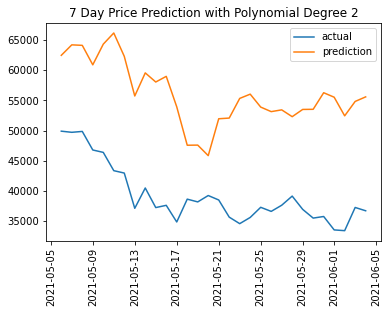

In [537]:
df_7_pred = plot_predictions(y_preds, y_7_test, '7 Day Price Prediction with Polynomial Degree 2')

## Analysis  of 7 Day Prediction:
The plot shows some similarity between the 7-day prediction and the actual 7-day price, but the R-squared value is not strong and this is not reliable enough for actual use.

**This model should not be used for 7 day price prediction**

## 3 Day Price Prediction

In [538]:
df_3_day.tail()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,3_day
3076,2021-06-04,1.290167e+06,1.355824e+20,9.039931e+22,686304,2.737743,2.579039e+06,47884,58529,861.091365,838490033,916649,809142,146493,16058,122974289,33577.694225
3077,2021-06-05,1.083917e+06,1.374711e+20,9.039931e+22,686435,2.250567,2.579840e+06,38637,45105,848.390854,838825932,772676,808581,146353,16048,123011623,33452.002255
3078,2021-06-06,9.487188e+05,1.567872e+20,9.039931e+22,686585,2.142998,2.580070e+06,33378,39821,960.078926,839134321,715945,808124,146322,16053,122948229,37290.991776
3079,2021-06-07,1.250725e+06,1.391161e+20,9.039931e+22,686718,2.723912,2.575684e+06,47350,55663,865.806271,839539074,907287,804696,146239,16070,122937997,36744.739308
3080,2021-06-08,1.286349e+06,1.556879e+20,9.039931e+22,686867,2.855984,2.571881e+06,55598,59802,966.497220,839961397,1002115,804479,146216,16072,122886946,36769.023139


In [539]:
# convert the index into the date
df_3_day.set_index('date', inplace=True)

In [540]:
# preprocess and split the features from the price data
feat_3_day, price_3_day = preprocess_data(df_3_day)

In [541]:
price_3_day.tail()

,3_day
date,
2021-06-04,33577.694225
2021-06-05,33452.002255
2021-06-06,37290.991776
2021-06-07,36744.739308
2021-06-08,36769.023139


In [542]:
feat_3_day

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2013-01-01,0.009112,2.867282e-08,4.336451e-10,0.000000,0.003398,0.000731,0.000075,0.000140,0.578680,0.000000,0.000000,0.001460,0.020764,0.005586,0.000000
2013-01-02,0.026710,2.335443e-08,4.336451e-10,0.000324,0.019792,0.000930,0.000233,0.000246,0.541335,0.000029,0.004021,0.001866,0.022516,0.000000,0.000125
2013-01-03,0.022457,2.963301e-08,4.336451e-10,0.000667,0.026021,0.000814,0.000168,0.000132,0.580777,0.000066,0.010160,0.002044,0.023358,0.004123,0.000244
2013-01-04,0.046200,2.190495e-08,4.336451e-10,0.000991,0.039684,0.000811,0.000346,0.000776,0.542435,0.000097,0.007202,0.001854,0.020916,0.009842,0.000328
2013-01-05,0.029636,1.399982e-08,4.336451e-10,0.001290,0.020172,0.001042,0.000168,0.000526,0.489899,0.000130,0.011873,0.001530,0.016239,0.016359,0.000462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-04,0.853119,6.851372e-01,8.403466e-01,0.998808,0.448351,0.843866,0.446899,0.214706,0.028894,0.998230,0.663353,0.968252,0.851246,0.669504,0.981695
2021-06-05,0.708183,6.946812e-01,8.403466e-01,0.999085,0.356904,0.844128,0.360534,0.165325,0.026721,0.998634,0.554710,0.967421,0.849314,0.668174,0.982001
2021-06-06,0.613176,7.922911e-01,8.403466e-01,0.999403,0.336712,0.844203,0.311416,0.145888,0.045825,0.999005,0.511901,0.966745,0.848887,0.668839,0.981481


Degree: 2
Train RMSE:  1068.148995475722
Train R2:  0.9890164278685812
Test RMSE:  1127.7761251159072
Test R2:  0.9894872856933022 


Validation RMSE:  12232.619674157642
Validation R2:  -6.976906485396685 




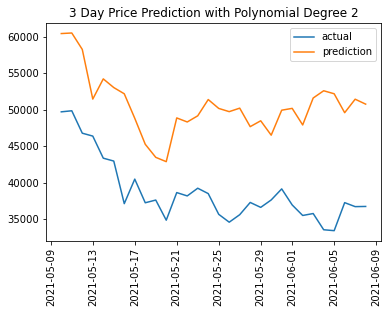

In [543]:
# create a prediction model with polynomial degree 2
y_pred_final, y_3_test = linear_predict(feat_3_day, price_3_day)

# plot the predictions and return the actual and predicted values dataframe
price_pred_7_day = plot_predictions(y_pred_final, y_3_test, "3 Day Price Prediction with Polynomial Degree 2")



In [544]:
y_3_test.head()

,3_day,predictions
date,,
2021-05-10,49729.302500,60451.402777
2021-05-11,49873.686392,60528.425591
2021-05-12,46803.830522,58276.137387
2021-05-13,46406.331544,51476.276084
2021-05-14,43382.147859,54241.106982


## Analysis of Predictions:

After looking at 1-day, 3-day, 7-day, and 180-day predictions, the 1-day prediction works best. This gives insight into the fact that these on-chain metrics are short term indicators. In order to determine, if there are set of long term indicators, various configurations of the features would need to be used and analyzed. Rather than do that analysis in this project, I will keep the focus on short term analysis. 

There are a few other targets that I would like to model:

    1-day price change
    log 1-day price
    2-day price
    log 2-day price

## 1-Day Change Prediction Model

Degree: 2
Train RMSE:  4.517878880375993
Train R2:  0.0933015086102944
Test RMSE:  4.289001604725359
Test R2:  -0.1522740620741938 


Validation RMSE:  5.59799153392567
Validation R2:  -0.026799427380558516 




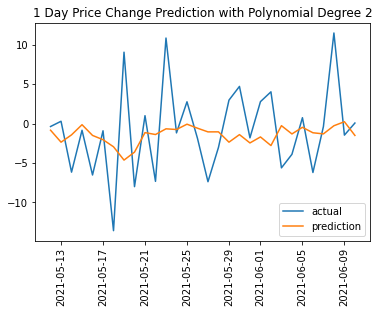

In [545]:
# convert the index into the date
df_1_day_change.set_index('date', inplace=True)

feat_1_day_change, price_1_day_change = preprocess_data(df_1_day_change)

# create a prediction model with polynomial degree 2
y_pred_final, y_change_test = linear_predict(feat_1_day_change, price_1_day_change, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_7_day = plot_predictions(y_pred_final, y_change_test, "1 Day Price Change Prediction with Polynomial Degree 2")


Degree: 3
Train RMSE:  3.5853699073860272
Train R2:  0.42896639927980273
Test RMSE:  14.548863097726528
Test R2:  -12.258716452532633 


Validation RMSE:  90.2964712847545
Validation R2:  -266.154627177842 




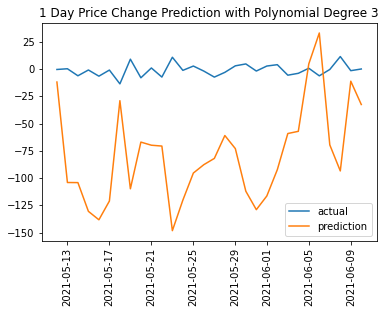

In [546]:
# create a prediction model with polynomial degree 3
y_pred_final, y_change_test = linear_predict(feat_1_day_change, price_1_day_change, deg=3)

# plot the predictions and return the actual and predicted values dataframe
price_pred_7_day = plot_predictions(y_pred_final, y_change_test, "1 Day Price Change Prediction with Polynomial Degree 3")


Degree: 1
Train RMSE:  4.713239226663839
Train R2:  0.013191929574540295
Test RMSE:  3.978395581361493
Test R2:  0.008576300661435221 


Validation RMSE:  5.77164818514089
Validation R2:  -0.0914927218634034 




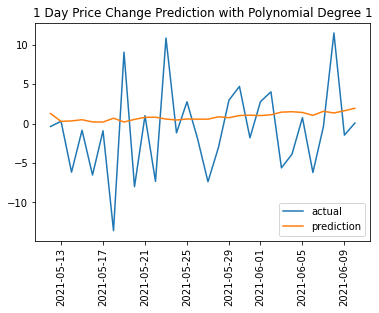

In [547]:
# create a prediction model with polynomial degree 1
y_pred_final, y_change_test = linear_predict(feat_1_day_change, price_1_day_change, deg=1)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_change = plot_predictions(y_pred_final, y_change_test, "1 Day Price Change Prediction with Polynomial Degree 1")


### Results of the 1-Day Price Change using polynomial regression are not good enough to use after looking at 3 different polynomial degrees.

## Log 1-Day Price Prediction Model

In [548]:
# create a column with values of the log of the 1-day price prediction
df_1_day['log_1_day'] = df_1_day['1_day'].apply(lambda x: np.log(x))
df_1_day.head()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,1_day,log_1_day
date,,,,,,,,,,,,,,,,,
2013-01-01,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297,13.034,2.567561
2013-01-02,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506,13.190,2.579459
2013-01-03,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036,13.174,2.578245
2013-01-04,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340,13.150,2.576422
2013-01-05,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604,13.150,2.576422


In [549]:
# drop the 1_day price column to only have the log target
df_1_day_log = df_1_day.drop(columns=['1_day'])
df_1_day_log.columns

Index(['ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', 'exchange_balance', 'exchange_withdrawals',
       'exchange_deposits', 'miner_revenue', 'total_addresses',
       'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo',
       'log_1_day'],
      dtype='object')

Degree: 2
Train RMSE:  0.14433037288552453
Train R2:  0.9936141897159423
Test RMSE:  0.15041132808311225
Test R2:  0.9933760026406275 


Validation RMSE:  0.39669414470147474
Validation R2:  -13.23100430591848 




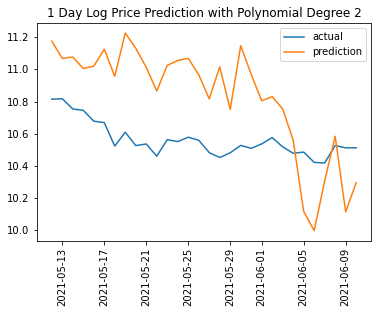

In [550]:
# normalize the data and covert into features and target dataframes
feat_1_day_log, price_1_day_log = preprocess_data(df_1_day_log)

# create a prediction model with polynomial degree 2
y_pred_final, y_change_test = linear_predict(feat_1_day_log, price_1_day_log, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_log = plot_predictions(y_pred_final, y_change_test, "1 Day Log Price Prediction with Polynomial Degree 2")


## Analysis of Log 1-Day Price Prediction:
This model looks  decent, but we can see the predicted values have much bigger change in values based on the features. The direction of predicted log price movement is very similar to the actual log price value. This could be promising, especially because the trianing and testing R-squared are so high. Some fine-tuning may result in ver good results.

## 2-Day Price Prediction:

In [551]:
price

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day
0,0.049510,2010-07-17,73.379115,0.085840,0.074733,0.062283,0.06529,0.1020,0.31880
1,0.085840,2010-07-18,-5.871389,0.080800,0.079210,0.054540,0.06550,0.1050,0.31760
2,0.080800,2010-07-19,-7.508251,0.074733,0.055945,0.050500,0.07000,0.1010,0.40000
3,0.074733,2010-07-20,5.990187,0.079210,0.062283,0.056000,0.06800,0.1020,0.38600
4,0.079210,2010-07-21,-29.371292,0.055945,0.054540,0.059844,0.06670,0.1024,0.38679
...,...,...,...,...,...,...,...,...,...
3978,33577.694225,2021-06-07,-0.374332,33452.002255,36744.739308,NaN,NaN,NaN,NaN
3979,33452.002255,2021-06-08,11.476113,37290.991776,36769.023139,NaN,NaN,NaN,NaN
3980,37290.991776,2021-06-09,-1.464838,36744.739308,NaN,NaN,NaN,NaN,NaN
3981,36744.739308,2021-06-10,0.066088,36769.023139,NaN,NaN,NaN,NaN,NaN


In [552]:
# narrow the date range of the data to between 1-1-2012 and 6-11-2021
price_dates = date_bool(price)

In [553]:
# create a new df of only the 2-day price
two_day = price_dates.iloc[2:, 0].reset_index().drop(columns='index').rename(columns={'price':'2_day'})

# add the 2-day price data to the dataframe
btc_final['2_day'] = two_day['2_day']

# create a new dataframe with features and the target 2-day price
df_2_day = create_dataframe(btc_final.iloc[:-2, :], '2_day')

df_2_day.head()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,2_day
0,2013-01-01,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297,13.190
1,2013-01-02,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506,13.174
2,2013-01-03,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036,13.150
3,2013-01-04,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340,13.150
4,2013-01-05,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604,13.200


In [554]:
# convert the index into the date
df_2_day.set_index('date', inplace=True)

feat_2_day, price_2_day = preprocess_data(df_2_day)

price_2_day.head(), price_2_day.tail()

(             2_day
 date              
 2013-01-01  13.190
 2013-01-02  13.174
 2013-01-03  13.150
 2013-01-04  13.150
 2013-01-05  13.200,
                    2_day
 date                    
 2021-06-05  33577.694225
 2021-06-06  33452.002255
 2021-06-07  37290.991776
 2021-06-08  36744.739308
 2021-06-09  36769.023139)

Degree: 2
Train RMSE:  1032.2627367674154
Train R2:  0.989290349717114
Test RMSE:  1195.2859654455824
Test R2:  0.9890838219102671 


Validation RMSE:  14181.887252317749
Validation R2:  -9.721699007224462 




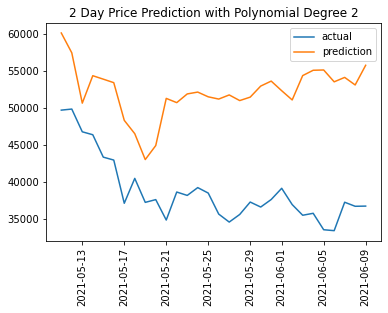

In [555]:
# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_2_day, price_2_day, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_2_day = plot_predictions(y_pred_final, y_test, "2 Day Price Prediction with Polynomial Degree 2")


## Analysis of 2-Day Price Prediction:

This model seems to perform worse than the 1-day prediction and the 3-day prediction. Further modeling will be done with the 1-day price prediction. 

Potential further analysis is to model the data based on a smaller window of data. This is due to the fact that the data does have some recency bias and the old data used to fit the model may be causing it to perform less accurately on the current predictions.

## Try adjusting the date range for 1-day price prediction
The following date windows for training and testing may provide better results for current predictions.

Test the following date windows:

    2014-2021 of data
    2015-2021 of data
    2016-2021 of data
    2017-2021 of data


In [556]:
# create dataframes of the different date ranges
seven_years = df_1_day[df_1_day.index >= dt.date(2014, 1, 1)]
six_years = df_1_day[df_1_day.index >= dt.date(2015, 1, 1)]
five_years = df_1_day[df_1_day.index >= dt.date(2016, 1, 1)]
four_years = df_1_day[df_1_day.index >= dt.date(2017, 1, 1)]

In [557]:
four_years.head()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,1_day,log_1_day
date,,,,,,,,,,,,,,,,,
2017-01-01,698539.769231,2.447999e+18,1.364461e+21,446188,2.087338,947441.441418,17159,24374,2015.079499,210176230,463375,548887,147876,18257,45746697,1014.355144,6.922008
2017-01-02,944877.641509,2.506491e+18,1.364461e+21,446347,3.365648,950238.353713,25612,35426,2100.384147,210525354,703943,546385,147679,18252,45813072,1024.435627,6.931897
2017-01-03,906573.518293,2.592320e+18,1.364461e+21,446511,3.489583,950090.448881,25814,34886,2167.508697,210886882,654405,544668,147549,18327,45931671,1120.566581,7.021590
2017-01-04,986063.189542,2.423386e+18,1.364461e+21,446664,3.801956,982207.844083,29966,40569,2105.837436,211279286,696039,544959,147580,18256,46019791,1002.922543,6.910674
2017-01-05,984196.892857,2.199553e+18,1.364461e+21,446804,3.337512,973458.977911,29913,38861,1864.991943,211629495,650948,546803,148114,18295,46041231,893.532221,6.795182


### Four Year Window

Degree: 2
Train RMSE:  1186.8630894536695
Train R2:  0.9899169417637722
Test RMSE:  1764.7104114023964
Test R2:  0.9836683744556384 


Validation RMSE:  17396.592666461656
Validation R2:  -15.133327274876116 




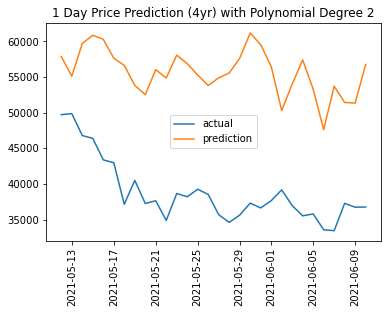

In [558]:
# drop the log_1_day column
four_years_1day = four_years.drop(columns=['log_1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_4yr, price_1_day_4yr = preprocess_data(four_years_1day)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_4yr, price_1_day_4yr, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_4yr = plot_predictions(y_pred_final, y_test, "1 Day Price Prediction (4yr) with Polynomial Degree 2")


## Five Year Window

Degree: 2
Train RMSE:  1214.6873842094717
Train R2:  0.989288748232273
Test RMSE:  1413.405077061028
Test R2:  0.9870702437702907 


Validation RMSE:  12253.145299732667
Validation R2:  -7.003698516160901 




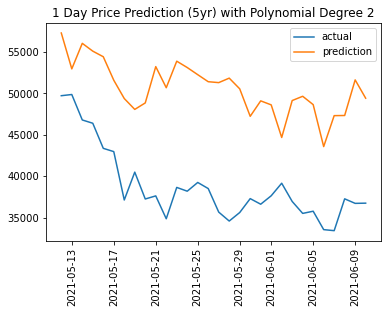

In [559]:
# drop the log_1_day column
five_years_1day = five_years.drop(columns=['log_1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_5yr, price_1_day_5yr = preprocess_data(five_years_1day)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_5yr, price_1_day_5yr, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_5yr = plot_predictions(y_pred_final, y_test, "1 Day Price Prediction (5yr) with Polynomial Degree 2")



### Six Year Window

Degree: 2
Train RMSE:  1166.267190564086
Train R2:  0.9887138661475783
Test RMSE:  1331.425574828588
Test R2:  0.9884752781029246 


Validation RMSE:  11739.098865756272
Validation R2:  -6.346239360684444 




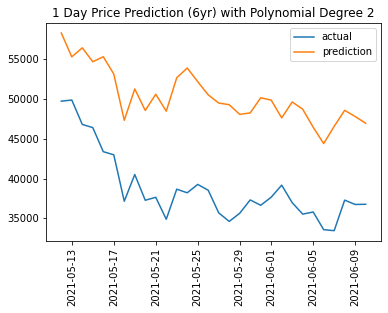

In [560]:
# drop the log_1_day column
six_years_1day = six_years.drop(columns=['log_1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_6yr, price_1_day_6yr = preprocess_data(six_years_1day)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_6yr, price_1_day_6yr, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_6yr = plot_predictions(y_pred_final, y_test, "1 Day Price Prediction (6yr) with Polynomial Degree 2")


### Seven Year Window

Degree: 2
Train RMSE:  1079.9416272722406
Train R2:  0.9896532572939786
Test RMSE:  1331.4601113250023
Test R2:  0.9866295625278867 


Validation RMSE:  13642.528001139784
Validation R2:  -8.921681054839615 




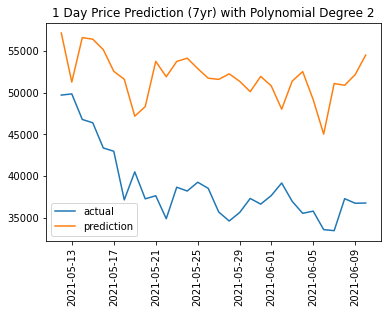

In [561]:
# drop the log_1_day column
seven_years_1day = seven_years.drop(columns=['log_1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_7yr, price_1_day_7yr = preprocess_data(seven_years_1day)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_7yr, price_1_day_7yr, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_7yr = plot_predictions(y_pred_final, y_test, "1 Day Price Prediction (7yr) with Polynomial Degree 2")


### Average the predictions of the two best models

5 year and 6 year windows for the 1-day price prediction seemed to perform the best.
Take the mean of the two predictions and view the results.


In [562]:
# copy the 5yr dataframe
ave_1day_pred = price_pred_1_day_5yr.copy()

# add the column of the 6 year predictions
ave_1day_pred['6yr_preds'] = price_pred_1_day_6yr['predictions']

# rename columns to distinguish different predictions
ave_1day_pred = ave_1day_pred.rename(columns={'predictions':'5yr_preds', '1_day':'actual_1day'})

ave_1day_pred['ave_preds'] = (ave_1day_pred['5yr_preds'] + ave_1day_pred['6yr_preds']) / 2 

ave_1day_pred.head()

,date,actual_1day,5yr_preds,6yr_preds,ave_preds
0,2021-05-12,49729.302500,57293.228077,58298.861769,57796.044923
1,2021-05-13,49873.686392,52964.349257,55298.370557,54131.359907
2,2021-05-14,46803.830522,56045.715442,56434.288021,56240.001732
3,2021-05-15,46406.331544,55104.196451,54687.123650,54895.660050
4,2021-05-16,43382.147859,54429.135373,55312.350697,54870.743035


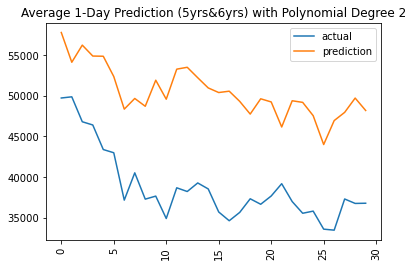

In [563]:
# plot the predictions and return the actual and predicted values dataframe
ave_predictions = plot_predictions(ave_1day_pred['ave_preds'], ave_1day_pred['actual_1day'], "Average 1-Day Prediction (5yrs&6yrs) with Polynomial Degree 2")


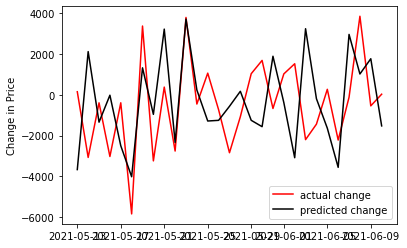

In [564]:
# create a column for the prediction values change and for the actual values change
ave_1day_pred['actual_change'] = ave_1day_pred['actual_1day'].diff().fillna(0)
ave_1day_pred['predicted_change'] = ave_1day_pred['ave_preds'].diff().fillna(0)

plt.plot(ave_1day_pred['date'].iloc[1:], ave_1day_pred['actual_change'].iloc[1:], label='actual change', color='red')
plt.plot(ave_1day_pred['date'].iloc[1:], ave_1day_pred['predicted_change'].iloc[1:], label='predicted change', color='black')
plt.ylabel('Change in Price')
plt.legend()
plt.show()

## Log 1-Day Price Prediction Model with Various Date Ranges

### Log Four Year Window

Degree: 2
Train RMSE:  0.08244229765141636
Train R2:  0.9908351037979437
Test RMSE:  0.10313079445738453
Test R2:  0.9884517702638974 


Validation RMSE:  0.6378606676893678
Validation R2:  -35.793882394303424 




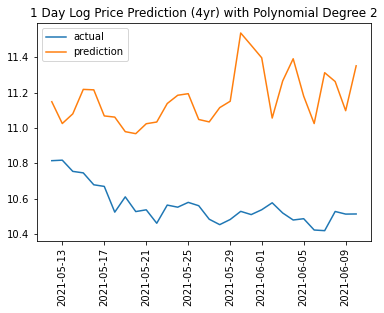

In [565]:
# drop the log_1_day column
four_years_log = four_years.drop(columns=['1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_4yrlog, price_1_day_4yrlog = preprocess_data(four_years_log)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_4yrlog, price_1_day_4yrlog, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_4yrlog = plot_predictions(y_pred_final, y_test, "1 Day Log Price Prediction (4yr) with Polynomial Degree 2")


### Log Five Year Window

Degree: 2
Train RMSE:  0.0855773908149206
Train R2:  0.995637922779636
Test RMSE:  0.0976407264657985
Test R2:  0.9941916110330034 


Validation RMSE:  0.41677296077537157
Validation R2:  -14.708077671215655 




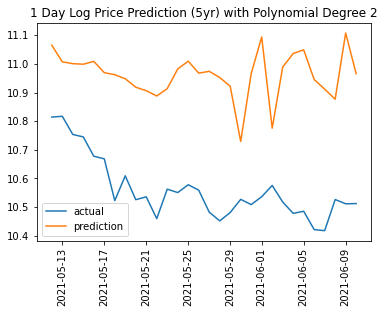

In [566]:
# drop the log_1_day column
five_years_log = five_years.drop(columns=['1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_5yrlog, price_1_day_5yrlog = preprocess_data(five_years_log)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_5yrlog, price_1_day_5yrlog, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_5yrlog = plot_predictions(y_pred_final, y_test, "1 Day Log Price Prediction (5yr) with Polynomial Degree 2")


### Log Six Year Window

Degree: 2
Train RMSE:  0.08802217616548452
Train R2:  0.9968237518117904
Test RMSE:  0.1045957042055548
Test R2:  0.9956758465381995 


Validation RMSE:  0.3902192361793624
Validation R2:  -12.770233943317718 




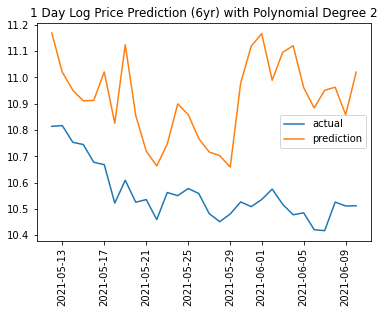

In [567]:
# drop the log_1_day column
six_years_log = six_years.drop(columns=['1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_6yrlog, price_1_day_6yrlog = preprocess_data(six_years_log)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_6yrlog, price_1_day_6yrlog, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_6yrlog = plot_predictions(y_pred_final, y_test, "1 Day Log Price Prediction (6yr) with Polynomial Degree 2")


### Log Seven Year Window

Degree: 2
Train RMSE:  0.10561428147984063
Train R2:  0.9954635608221881
Test RMSE:  0.12164909555625243
Test R2:  0.9942785990726405 


Validation RMSE:  0.4060818623243835
Validation R2:  -13.912523938998861 




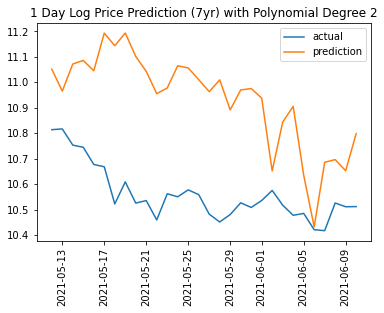

In [568]:
# drop the log_1_day column
seven_years_log = seven_years.drop(columns=['1_day'])

# normalize the data and covert into features and target dataframes
feat_1_day_7yrlog, price_1_day_7yrlog = preprocess_data(seven_years_log)

# create a prediction model with polynomial degree 2
y_pred_final, y_test = linear_predict(feat_1_day_7yrlog, price_1_day_7yrlog, deg=2)

# plot the predictions and return the actual and predicted values dataframe
price_pred_1_day_7yrlog = plot_predictions(y_pred_final, y_test, "1 Day Log Price Prediction (7yr) with Polynomial Degree 2")


## Results of training the other price predictions:

From the previously run data, we know that one_day_price prediction is best with polynomial degrees 2

As well, 180 day and 7 day price prediction also performed best with polynomial degrees 2

30 day and 90 day price prediction had their highest test R2 with polynomial degrees 3, but there was also some divergence between the training R2 and the testing R2 for each of those datasets. 

Because of the divergence my inclination is to make predictions based on polynomial degrees 2 since there is no divergence at polynomial degrees 2 and the R2 is above 0.95 for each of the datasets.


## Testing out different Regression Models on the Data

Some popular regression models that have not been used in this analysis are Lasso and Ridge Regression.

### Ridge Regression
Ridge Regression performs L2 regularization. It optimizes the following:

**Objective = RSS + alpha * (sum of square of coefficients)**

Where alpha is a parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients


In [ ]:
from sklearn.linear_model import Ridge

#### 180 Day Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_180_day, target_180_day, test_size=0.3, random_state=10)

def ridge_reg(X_train, X_test, y_train, y_test):
    for a in [0.0001, 0.001, 0.01, 0.1, 1]:
        ridgereg = Ridge(alpha=a)
        ridgereg.fit(X_train, y_train)
        y_train_pred = ridgereg.predict(X_train)
    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
    
        print('---------------------------')
        print('Alpha: ', a)
        print('Train RMSE: ', train_rmse)
        print('Train R2: ', train_r2)
    
    
        y_test_pred = ridgereg.predict(X_test)
    
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
    
        print('Train RMSE: ', test_rmse)
        print('Train R2: ', test_r2)
        print('---------------------------')
        

print('Ridge Regression on 180 day price prediction:')        
ridge_reg(X_train, X_test, y_train, y_test)

#### 90 Day Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_90_day, target_90_day, test_size=0.3, random_state=10)

print('Ridge Regression on 90 day price prediction:')        
ridge_reg(X_train, X_test, y_train, y_test)

#### 30 Day Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_30_day, target_30_day, test_size=0.3, random_state=10)

print('Ridge Regression on 30 day price prediction:')        
ridge_reg(X_train, X_test, y_train, y_test)

#### 7 Day Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_7_day, target_7_day, test_size=0.3, random_state=10)

print('Ridge Regression on 7 day price prediction:')        
ridge_reg(X_train, X_test, y_train, y_test)

#### 1 Day Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_1_day, target_1_day, test_size=0.3, random_state=10)

print('Ridge Regression on 30 day price prediction:')        
ridge_reg(X_train, X_test, y_train, y_test)

### Perform Ridge Regression on the Polynomial Function:

In [ ]:
def polynomial_ridge(X_train, X_test, y_train, y_test):
    #create variable to updated through iterations
    max_test_r2 = 0
    
    # create the polynomial object
    polynomial_features = PolynomialFeatures(degree = 2)
    
    # perform the polynomial transformation 
    X_TRANSF = polynomial_features.fit_transform(X_train)
    
    # loop through the alpha values
    alphas = [0.0001, 0.001, 0.01, 0.1, 1]
    for a in alphas:
    
        # create the ridge regression model
        model = Ridge(alpha=a)

        # train the model
        model.fit(X_TRANSF, y_train)
    
        y_train_pred = model.predict(X_TRANSF)
    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
    
        print('---------------------------')
        print('Degree: ', 2, '  Alpha: ', a)
        print('Train RMSE: ', train_rmse)
        print('Train R2: ', train_r2)
    
        predict_poly = polynomial_features.fit_transform(X_test)
    
        Y_NEW = model.predict(predict_poly)
   
        test_rmse = np.sqrt(mean_squared_error(y_test, Y_NEW))
        test_r2 = r2_score(y_test, Y_NEW)
        
        # keep the highest performing test r2 results:
        if test_r2 > max_test_r2:
            max_a, max_train_rmse, max_train_r2, max_test_rmse, max_test_r2 = \
                    a, train_rmse, train_r2, test_rmse, test_r2 

        print('Test RMSE: ', test_rmse)
        print('Test R2: ', test_r2, '\n\n')
        
    # print the best results
    print('---------------------------------------')
    print('Best Results are:')
    print('Alpha: ', max_a)
    print('Train RMSE: ', max_train_rmse)
    print('Train R2: ', max_train_r2 )
    print('Test RMSE: ', max_test_rmse)
    print('Test R2: ', max_test_r2)
    

### 180 day price prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_180_day, target_180_day, test_size=0.3, random_state=10)

polynomial_ridge(X_train, X_test, y_train, y_test)

### 90 Day Price Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_90_day, target_90_day, test_size=0.3, random_state=10)

polynomial_ridge(X_train, X_test, y_train, y_test)

### 30 day price prediction

In [580]:
X_train, X_test, y_train, y_test = train_test_split(features_30_day, target_30_day, test_size=0.3, random_state=10)

polynomial_ridge(X_train, X_test, y_train, y_test)

NameError: name 'features_30_day' is not defined

### 7 Day Price Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_7_day, target_7_day, test_size=0.3, random_state=10)

polynomial_ridge(X_train, X_test, y_train, y_test)

### 1 Day Price Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_1_day, target_1_day, test_size=0.3, random_state=10)

polynomial_ridge(X_train, X_test, y_train, y_test)

## Results from the Ridge Regression Analysis:

For one day and seven day price prediction with an alpha of 0.0001, the test R2 looks strong at 0.9868 and 0.9826 respectively.

The best test R2 results are 0.9877 for one day price prediction with polynomial degree 2 and no ridge regression

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

# create a lasso regression function
def lasso_reg(X_train, X_test, y_train, y_test):
    for a in [1e-08, 1e-05, 0.0001, 0.01]:
        lassoreg = Lasso(alpha=a, max_iter=1e5)
        lassoreg.fit(X_train, y_train)
        y_train_pred = lassoreg.predict(X_train)
    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
    
        print('---------------------------')
        print('Alpha: ', a)
        print('Train RMSE: ', train_rmse)
        print('Train R2: ', train_r2)
    
    
        y_test_pred = lassoreg.predict(X_test)
    
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
    
        print('Train RMSE: ', test_rmse)
        print('Train R2: ', test_r2)
        print('---------------------------')
        


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_180_day, target_180_day, test_size=0.3, random_state=10 )
print('Lasso Regression on 180 day price prediction:')        
lasso_reg(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_90_day, target_90_day, test_size=0.3, random_state=10 )
print('Lasso Regression on 90 day price prediction:')        
lasso_reg(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_30_day, target_30_day, test_size=0.3, random_state=10 )
print('Lasso Regression on 30 day price prediction:')        
lasso_reg(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_7_day, target_7_day, test_size=0.3, random_state=10 )
print('Lasso Regression on 7 day price prediction:')        
lasso_reg(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_1_day, target_1_day, test_size=0.3, random_state=10 )
print('Lasso Regression on 1 day price prediction:')        
lasso_reg(X_train, X_test, y_train, y_test)

## Polynomial Lasso Regression

In [ ]:
# create a polynomial lasso regression function
def poly_lasso(X_train, X_test, y_train, y_test):
    #create variable to updated through iterations
    max_test_r2 = 0
    
    # create the polynomial object
    polynomial_features = PolynomialFeatures(degree = 2)
    
    # perform the polynomial transformation 
    X_TRANSF = polynomial_features.fit_transform(X_train)
    
    
    for a in [0.00001]:
        lassoreg = Lasso(alpha=a, max_iter=1e5)
        lassoreg.fit(X_TRANSF, y_train)
        y_train_pred = lassoreg.predict(X_TRANSF)
    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
    
        print('---------------------------')
        print('Alpha: ', a)
        print('Train RMSE: ', train_rmse)
        print('Train R2: ', train_r2)
    
        # perform polynomial transformation on test data
        X_TRANSF_TEST = polynomial_features.fit_transform(X_test)
        
        y_test_pred = lassoreg.predict(X_TRANSF_TEST)
    
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        
        # update the max_test_r2
        if test_r2 > max_test_r2:
            max_a, max_train_rmse, max_train_r2, max_test_rmse, max_test_r2 = \
                    a, train_rmse, train_r2, test_rmse, test_r2
        
    
        print('Test RMSE: ', test_rmse)
        print('Test R2: ', test_r2)
        print('---------------------------')
        
#     print('Best Results for this test:')
#     print('Alpha: ', max_a)
#     print('Train RMSE: ', max_train_rmse)
#     print('Train R2: ', max_train_r2)
#     print('Test RMSE: ', max_test_rmse)
#     print('Test R2: ', max_test_r2)
    


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_1_day, target_1_day, test_size=0.3, random_state=10 )
print('Polynomial Lasso Regression on 1 day price prediction:')        
poly_lasso(X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_7_day, target_7_day, test_size=0.3, random_state=10 )
print('Polynomial Lasso Regression on 7 day price prediction:')        
poly_lasso(X_train, X_test, y_train, y_test)

## Results from Multiple Linear Regression Model Analysis:

Polynomial Linear Regression performed the best with polynomial degrees of 2:

